In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, make_scorer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [2]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

In [3]:
genetic_selected_names = ['ptt_min','inr_max','calcium_min.1','temperature_mean','glucose_min','glucose_mean','weight_admit','aniongap_max','aniongap_min','potassium_min.1','bicarbonate_max.1','chloride_max.1','gcs_verbal','hemoglobin_min.1','hematocrit_min.1','bun_max','gcs_eyes','resp_rate_max','resp_rate_min','spo2_mean','spo2_min','dbp_min','sbp_mean','sbp_min','heart_rate_max','heart_rate_mean','race','admission_age']
genetic_selected_names.append('aki')
train = train.loc[:, genetic_selected_names]
test = test.loc[:, genetic_selected_names]

## Try

In [25]:
y = train['aki'].astype(float)
X = train.drop(['aki'], axis=1)

In [26]:
def train_model(df, model):
    y = df['aki'].astype(float)
    X = df.drop(['aki'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

In [27]:
model = AdaBoostClassifier()
train_model(train, model)


Accuracy: 0.4741085271317829
              precision    recall  f1-score   support

         0.0       0.51      0.70      0.59      3157
         1.0       0.39      0.00      0.01      1904
         2.0       0.44      0.59      0.50      3059
         3.0       0.47      0.37      0.42      1555

    accuracy                           0.47      9675
   macro avg       0.45      0.42      0.38      9675
weighted avg       0.46      0.47      0.42      9675



In [50]:
aa = train[train["aki"].isin([0, 1])]

In [51]:
model = AdaBoostClassifier()
train_model(aa, model)

Accuracy: 0.6624066063704286
              precision    recall  f1-score   support

         0.0       0.69      0.85      0.76      3242
         1.0       0.56      0.33      0.41      1844

    accuracy                           0.66      5086
   macro avg       0.62      0.59      0.59      5086
weighted avg       0.64      0.66      0.64      5086



In [52]:
def ttt(train, y_val):
    aa = train[train["aki"].isin(y_val)]
    model = AdaBoostClassifier()
    train_model(aa, model)

In [53]:
ttt(train, [1,2])

Accuracy: 0.6337092227144583
              precision    recall  f1-score   support

         1.0       0.52      0.25      0.33      1860
         2.0       0.66      0.87      0.75      3106

    accuracy                           0.63      4966
   macro avg       0.59      0.56      0.54      4966
weighted avg       0.61      0.63      0.59      4966



In [40]:
y = aa['aki'].astype(float)
X = aa.drop(['aki'], axis=1)

In [47]:
X.shape

(25429, 63)

In [54]:
param_dist = {
    "n_estimators": [300, 350, 400, 450],
    "learning_rate": [0.01, 0.1, 1.0],
    "algorithm":["SAMME", "SAMME.R"]
}
model = AdaBoostClassifier(random_state=20)
search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="accuracy", cv=5, n_iter=10)
search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=20),
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.01, 0.1, 1.0],
                                        'n_estimators': [300, 350, 400, 450]},
                   scoring='accuracy')

In [55]:
search.best_params_

{'n_estimators': 400, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}

In [56]:
search.best_score_

0.6632589122936041

In [18]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4793798449612403


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.70      0.60      3157
         1.0       0.00      0.00      0.00      1904
         2.0       0.43      0.65      0.52      3059
         3.0       0.54      0.27      0.36      1555

    accuracy                           0.48      9675
   macro avg       0.37      0.41      0.37      9675
weighted avg       0.39      0.48      0.42      9675



## Adjust Parameters

### Draw parameters with the Accurancy 2D curve to select the appropriate interval

In [4]:
y_train = train['aki'].astype(float)
X_train = train.drop(['aki'], axis=1)
y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)

def train_rf(X_train, y_train, parameters): 
    rf = AdaBoostClassifier(
        n_estimators = parameters['n_estimators'],
        learning_rate = parameters['learning_rate'],
        algorithm = parameters['algorithm'],
    )
    rf.fit(X_train, y_train)
    return accuracy_score(y_test,rf.predict(X_test))

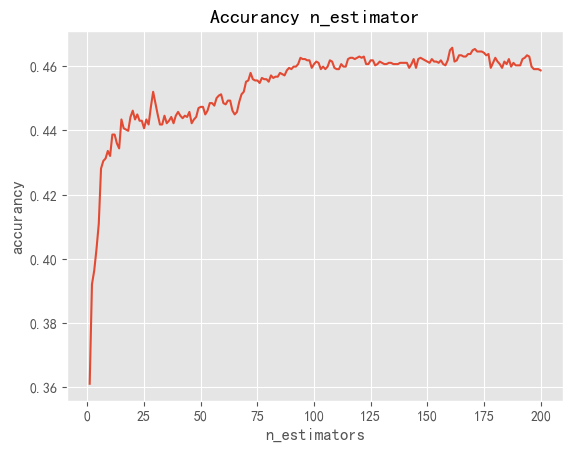

In [5]:
parameters = {       
    'n_estimators': 50,
    "learning_rate": 1.0,
    "algorithm": "SAMME.R"
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in range(1,201):
    parameters['n_estimators'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(range(1,201),accurancyList['precision'])
plt.xlabel('n_estimators')
plt.ylabel('accurancy')
plt.title('Accurancy n_estimator')
plt.show()

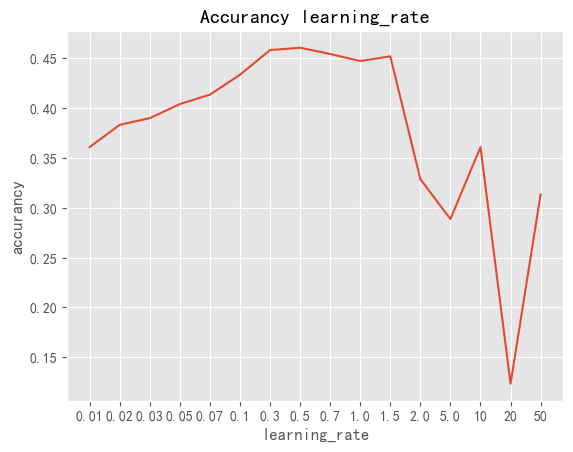

In [6]:
parameters = {       
    'n_estimators': 50,
    "learning_rate": 1.0,
    "algorithm": "SAMME.R"
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10, 20, 50]:
    parameters['learning_rate'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot([str(i) for i in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10, 20, 50]],accurancyList['precision'])
plt.xlabel('learning_rate')
plt.ylabel('accurancy')
plt.title('Accurancy learning_rate')
plt.show()

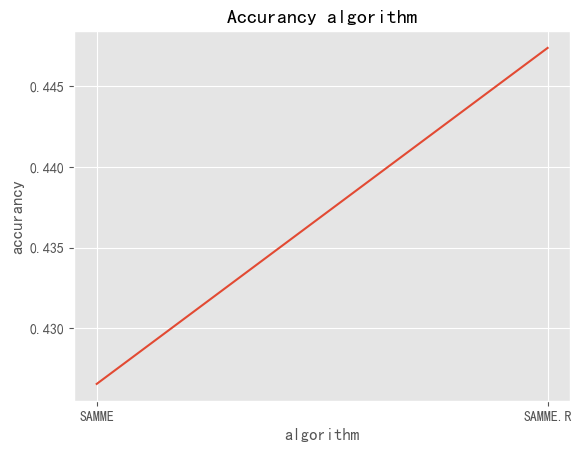

In [8]:
parameters = {       
    'n_estimators': 50,
    "learning_rate": 1.0,
    "algorithm": "SAMME.R"
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in ["SAMME", "SAMME.R"]:
    parameters['algorithm'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(["SAMME", "SAMME.R"],accurancyList['precision'])
plt.xlabel('algorithm')
plt.ylabel('accurancy')
plt.title('Accurancy algorithm')
plt.show()

### RandomizedSearch

In [14]:
param_dist = {
    'n_estimators': np.arange(155, 175, 2),
    "learning_rate": np.arange(0.45, 0.55, 0.01),
}
model = AdaBoostClassifier(algorithm="SAMME.R", random_state=20)
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="accuracy", cv=5, n_iter=10)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("AdaBoost AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

best_params {'n_estimators': 163, 'learning_rate': 0.47000000000000003}
best_score 0.4818498578197027
------------------------------------------------------------------
AdaBoost AUC (Macro): 0.6718850181982103
              precision    recall  f1-score   support

         0.0       0.49      0.64      0.56       808
         1.0       0.25      0.00      0.00       461
         2.0       0.42      0.57      0.48       837
         3.0       0.50      0.39      0.44       440

    accuracy                           0.46      2546
   macro avg       0.42      0.40      0.37      2546
weighted avg       0.43      0.46      0.41      2546

------------------------------------------------------------------
train accuracy: 0.4866870632984661, test accuracy: 0.4595443833464258


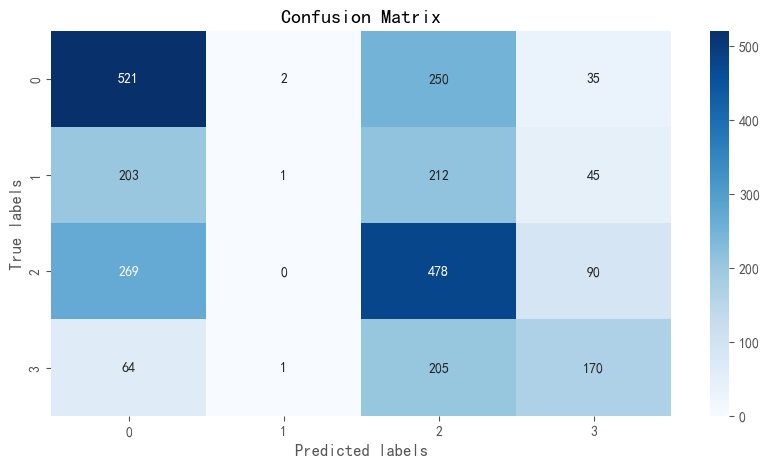

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Sample imbalance problem

### Smote

In [4]:
def train_model(train, test, model):
    y = train['aki'].astype(float)
    X = train.drop(['aki'], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=20)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print("valid accuracy:", accuracy)
    print(classification_report(y_valid, y_pred))

    y_pred_proba = model.predict_proba(X_valid)
    auc_macro = roc_auc_score(y_valid, y_pred_proba, multi_class="ovr", average="macro")
    print("DecisionTree Valid AUC (Macro):", auc_macro)

    print('------------------------------------------------------------------')
    y_test = test['aki'].astype(float)
    X_test = test.drop(['aki'], axis=1)
    best_model = model
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    y_pred_proba = best_model.predict_proba(X_test)
    auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
    print("DecisionTree Test AUC (Macro):", auc_macro)
    print(classification_report(y_test, y_pred_test))
    print('------------------------------------------------------------------')
    print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')
    return model

In [5]:
y_train = train['aki'].astype(float)
X_train = train.drop(['aki'], axis=1)
y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)

In [6]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=20)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [7]:
model = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=169, learning_rate=0.47, random_state=20)
train_model(X_train_resampled, test, model)

valid accuracy: 0.49711882884285935
              precision    recall  f1-score   support

         0.0       0.51      0.61      0.56      3192
         1.0       0.48      0.28      0.35      3285
         2.0       0.41      0.47      0.44      3144
         3.0       0.57      0.64      0.60      3221

    accuracy                           0.50     12842
   macro avg       0.49      0.50      0.49     12842
weighted avg       0.50      0.50      0.49     12842

DecisionTree Valid AUC (Macro): 0.7377460237863622
------------------------------------------------------------------
DecisionTree Test AUC (Macro): 0.6629042064464253
              precision    recall  f1-score   support

         0.0       0.52      0.57      0.54       808
         1.0       0.19      0.10      0.13       461
         2.0       0.44      0.44      0.44       837
         3.0       0.41      0.54      0.47       440

    accuracy                           0.44      2546
   macro avg       0.39      0.41  

AdaBoostClassifier(learning_rate=0.47, n_estimators=169, random_state=20)

### Adjust evaluation index

In [9]:
def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    return roc_auc_score(y_true, y_pred, average=average)

multi_roc_auc = make_scorer(multiclass_roc_auc_score)

In [11]:
y_train = X_train_resampled['aki'].astype(float)
X_train = X_train_resampled.drop(['aki'], axis=1)

In [12]:
param_dist = {
    'n_estimators': np.arange(155, 175, 2),
    "learning_rate": np.arange(0.45, 0.55, 0.01),
}
model = AdaBoostClassifier(algorithm="SAMME.R", random_state=20)
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=multi_roc_auc, cv=5, n_iter=10, n_jobs=-1)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("AdaBoost AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

best_params {'n_estimators': 157, 'learning_rate': 0.51}
best_score nan
------------------------------------------------------------------
AdaBoost AUC (Macro): 0.6626319742643392
              precision    recall  f1-score   support

         0.0       0.52      0.57      0.54       808
         1.0       0.19      0.11      0.14       461
         2.0       0.44      0.43      0.44       837
         3.0       0.40      0.52      0.46       440

    accuracy                           0.43      2546
   macro avg       0.39      0.41      0.39      2546
weighted avg       0.41      0.43      0.42      2546

------------------------------------------------------------------
train accuracy: 0.5027878146025417, test accuracy: 0.43205027494108406
